# Testing ApRES
Notes on testing three ApRES units. 

They arrived at Lamont on Thursday May 30th 2024. They need to be shipping at of the following week (Friday June 6th).

Below are notes on the tests I ran outside the machine shop on the afternoon of Froday May 31st. 

George Lu created a config file (data/apres-test-ldeo-may31-2024/data/config.ini) with
- repeat time of 30 seconds
- two pairs of attenuator settings (6 and -14, 10 and -4)
- number of chirps per subburst = 2

I used GPSon = 1, meaning the unit will wiat for a gps lock before starting a burst, but for the unit that the internal GPS cable is broken I set GPSon = 0.

I used the same pair of SD cards for each unit. For each test I turned on the unit without the ethernet cable connected, waited a few minutes so tht a few unattended burst were collected, then turned off the unit.

This table summarizes the timing of the tests:
Table 1: Timing of tests
| serial number of unit | Start time (UTC) | End time (UTC) | File where results are saved | Notes |
|-----------------------|------------------|----------------|------------------------------|-------|
|205| 1932 | 1937| data/apres-test-ldeo-may31-2024/data/DIR2024-05-31-1932/DATA2024-05-31-1932.DAT | |
|206| 1920 | not recorded | data/apres-test-ldeo-may31-2024/data/DIR2024-05-31-0320/DATA2024-05-31-0320.DAT| GPS not working, so time was set incorrectly|
|207| 1901| 1903| data/apres-test-ldeo-may31-2024/data/DIR2024-05-31-1901/DATA2024-05-31-1901.DAT| |

The gps in unit 206 is not currently working, so I set the time manually for that test. I incorrectly set the time to 0320 instead of 1920, i.s. I used local time instead of UTC. Hence why the file name has 0320 in it instead of 1920.


## load package
We will use a package we developed for reading and processing ApRES data using xarray called XApRES. 

In [1]:
import sys
sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres")
import xapres as xa

We'll put the file names in a dictionary for ueasier use later.

In [26]:
directories = {'205': 'data/DIR2024-05-31-1932', 
               '206': 'data/DIR2024-05-31-0320',
               '207': 'data/DIR2024-05-31-1901',
               '207_secondTest': 'data/DIR2024-06-03-1758'}

## 205
Loading the data from unit 205.

In [28]:
directories['205']

'data/DIR2024-05-31-1932'

In [27]:
test_205 = xa.load.generate_xarray(directory=directories['205'])
test_205

<xarray.Dataset>
Dimensions:          (time: 10, chirp_time: 40001, chirp_num: 2,
                      attenuator_setting_pair: 2, profile_range: 16644)
Coordinates:
  * time             (time) datetime64[ns] 2024-05-31T19:32:55 ... 2024-05-31...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 3.5e+03 3.5e+03
  * chirp_num        (chirp_num) int64 0 1
    filename         (time) <U47 'data/DIR2024-05-31-1932/DATA2024-05-31-1932...
    burst_number     (time) int64 0 1 2 3 4 5 6 7 8 9
    AFGain           (attenuator_setting_pair) int64 -14 -4
    attenuator       (attenuator_setting_pair) float64 6.0 10.0
    orientation      (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    longitude        (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    battery_voltage  (time) float64 12.4 12.41 12.41 12.42 ... 12.42 12.42 12.42
    temperature_1    (time) float64 32.43 31.84 34.78 30.86 ... 28.9 30.47 28.9
    temperature_2    (time) float64 32.98 33.77 32.2 33.57 ... 33.18 34.36 33.57

We see that there were ten bursts (because the time dimension has a length of 10).   


In [4]:
test_205.time.size

10

The first burst started at 19:32:55 and they settled in to a regular pattern of one burst every 30 seconds. 

In [5]:
(test_205.time.values[1:] - test_205.time.values[:-1])/1e9 # the /1e9 is becuase the time is in nanoseconds

array([22, 30, 30, 30, 30, 30, 30, 30, 30], dtype='timedelta64[ns]')

You can plot some random things like the tmperature in the ApRES box and the battery voltage:

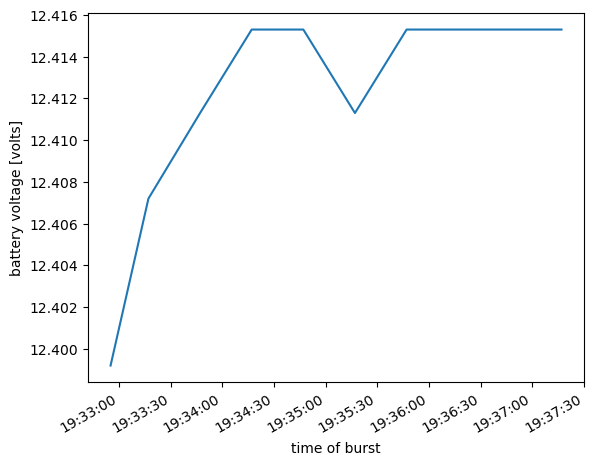

In [6]:
test_205.battery_voltage.plot();

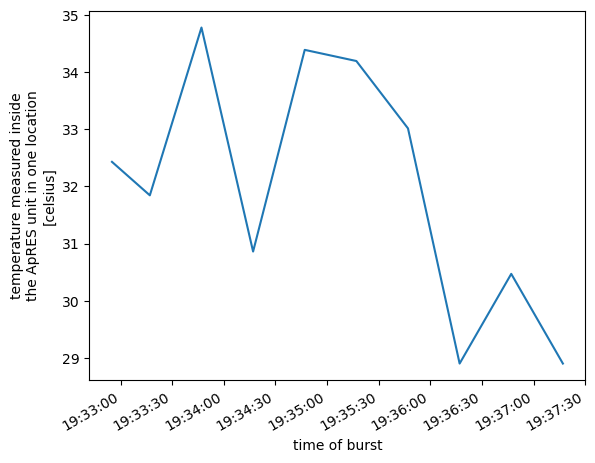

In [7]:
test_205.temperature_1.plot()

But more importantly, yo ucan plot the chirps and the profiles:

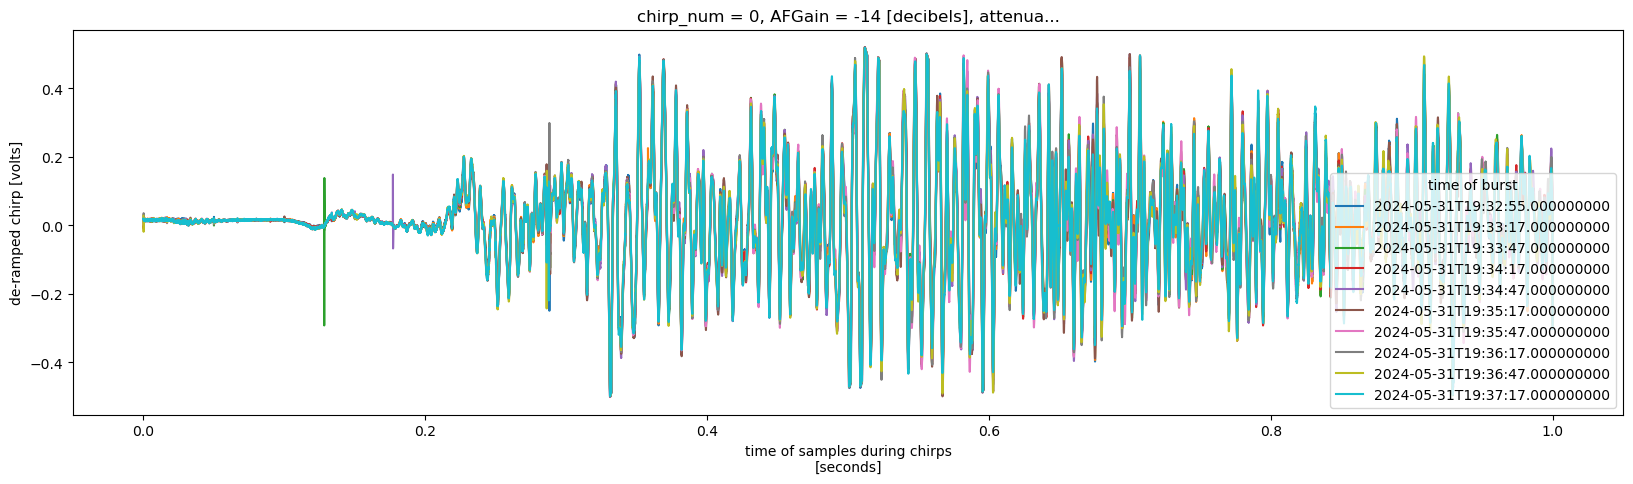

In [8]:
test_205.chirp.isel(attenuator_setting_pair=0, chirp_num=0).plot.line(x='chirp_time',figsize=(20,5));

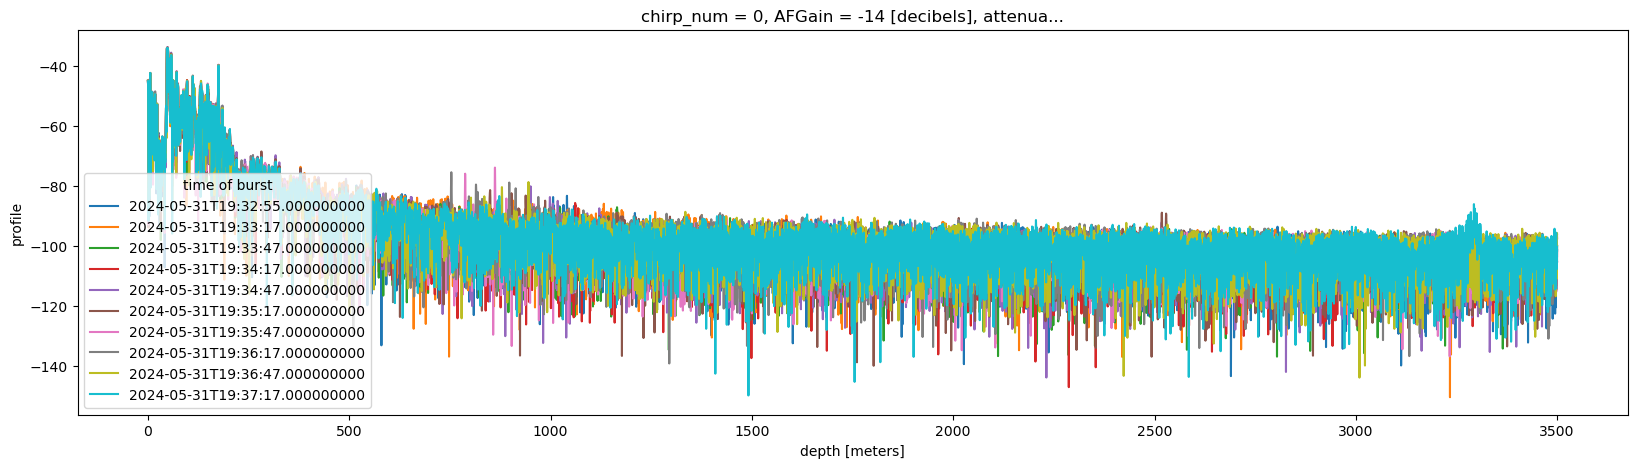

In [9]:
test_205.profile.isel(attenuator_setting_pair=0, chirp_num=0).dB().plot.line(x='profile_range',figsize=(20,5));

You can also sonfiy a chirp

In [10]:
test_205.chirp.isel(attenuator_setting_pair=0, chirp_num=0, time=0).sonify(save=True)

The result is saved a .wav file called chirp.wav.

## 206
If we try to load the dat file from the test of 206 we get an error. I think this is due me turning off the unit before it was done writing the last burst to disk:

In [25]:
try:
    test_206 = xa.load.generate_xarray(directory=directories['206'])
except:
    print('Failed to load test 206')

Failed to load test 206


We can access information on the dat file using `xapres.load.DataFileObject`. For example, we can see how many bursts there are in the file.

In [12]:
fileDescriptor = xa.load.DataFileObject('data/DIR2024-05-31-0320/DATA2024-05-31-0320.DAT')
fileDescriptor.NoBurstsInFile

7

Then we can just load all-but-the-last burst, as follows

In [13]:
test_206 = xa.load.generate_xarray(directory=directories['206'], bursts_to_process=list(range(0, fileDescriptor.NoBurstsInFile-1)))
test_206

<xarray.Dataset>
Dimensions:          (time: 6, chirp_time: 40001, chirp_num: 2,
                      attenuator_setting_pair: 2, profile_range: 16644)
Coordinates:
  * time             (time) datetime64[ns] 2024-05-31T03:20:45 ... 2024-05-31...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 3.5e+03 3.5e+03
  * chirp_num        (chirp_num) int64 0 1
    filename         (time) <U47 'data/DIR2024-05-31-0320/DATA2024-05-31-0320...
    burst_number     (time) int64 0 1 2 3 4 5
    AFGain           (attenuator_setting_pair) int64 -14 -4
    attenuator       (attenuator_setting_pair) float64 6.0 10.0
    orientation      (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0
    longitude        (time) float64 0.0 0.0 0.0 0.0 0.0 0.0
    battery_voltage  (time) float64 12.42 12.43 12.43 12.43 12.43 12.43
    temperature_1    (time) float64 31.62 28.1 25.55 27.91 27.91 28.3
    temperature_2    (time) float64 27.96 28.75 29.73 31.5 34.64 34.45

In [14]:
(test_206.time.values[1:] - test_206.time.values[:-1])/1e9 # the /1e9 is because the time is in nanoseconds

array([22, 30, 30, 30, 30], dtype='timedelta64[ns]')

This time let's try a different way of plotting: let's take just one of the attenuator settings and take the average of all the chirps in each burst, then plot every so-called stacked profile as a color map. 

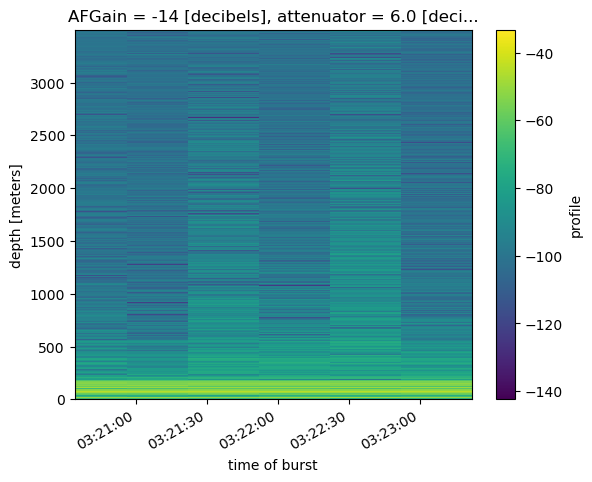

In [15]:
test_206.profile.mean(dim='chirp_num').dB().isel(attenuator_setting_pair=0).plot(x='time')

## 207

In [16]:
test_207 = xa.load.generate_xarray(directory=directories['207'])
test_207

<xarray.Dataset>
Dimensions:          (time: 4, chirp_time: 40001, chirp_num: 2,
                      attenuator_setting_pair: 2, profile_range: 16644)
Coordinates:
  * time             (time) datetime64[ns] 2024-05-31T19:02:34 ... 2024-05-31...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 3.5e+03 3.5e+03
  * chirp_num        (chirp_num) int64 0 1
    filename         (time) <U47 'data/DIR2024-05-31-1901/DATA2024-05-31-1901...
    burst_number     (time) int64 0 1 2 3
    AFGain           (attenuator_setting_pair) int64 -14 -4
    attenuator       (attenuator_setting_pair) float64 6.0 10.0
    orientation      (time) <U7 'unknown' 'unknown' 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 41.0 41.0 41.0 41.0
    longitude        (time) float64 -73.91 -73.91 -73.91 -73.91
    battery_voltage  (time) float64 12.31 12.31 12.3 12.29
    temperature_1    (time) float64 35.15 33.39 34.56 34.56
    temperature_2    (time) float64 27.33 26.35 27.13 27.13

The timing of the chirps seems odd:

In [17]:
(test_207.time.values[1:] - test_207.time.values[:-1])/1e9 # the /1e9 is because the time is in nanoseconds

array([51, 12, 12], dtype='timedelta64[ns]')

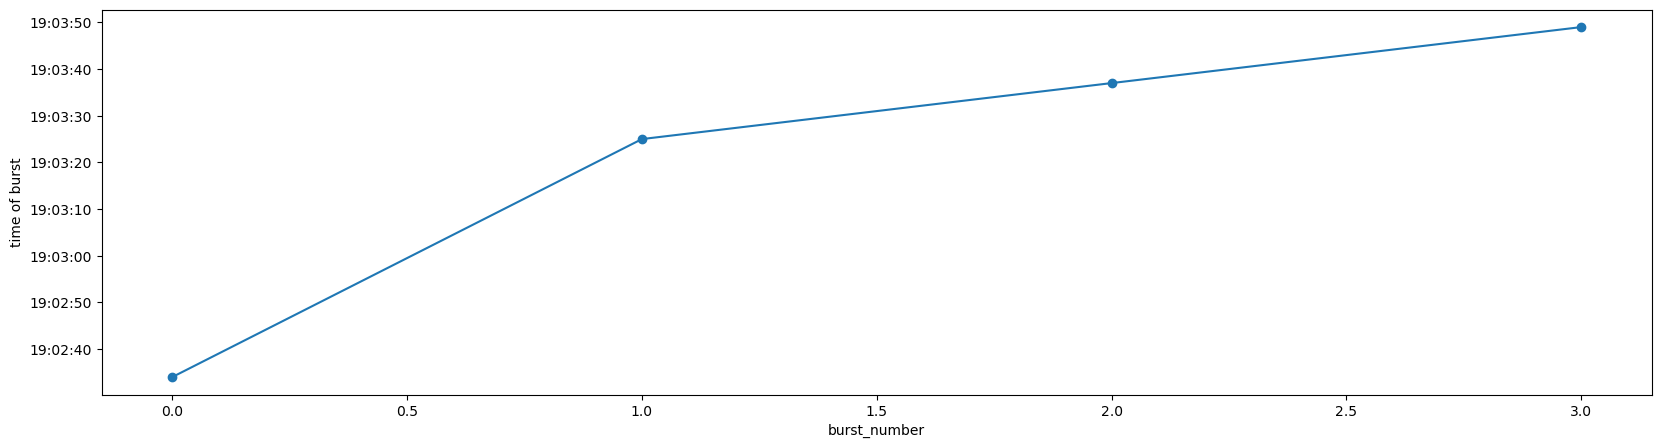

In [18]:
test_207.time.plot.line(x='burst_number', marker='o',figsize=(20,5));


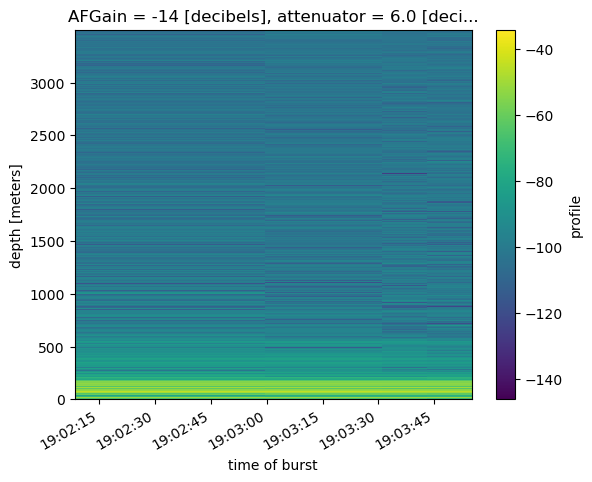

In [19]:
test_207.profile.mean(dim='chirp_num').dB().isel(attenuator_setting_pair=0).plot(x='time')

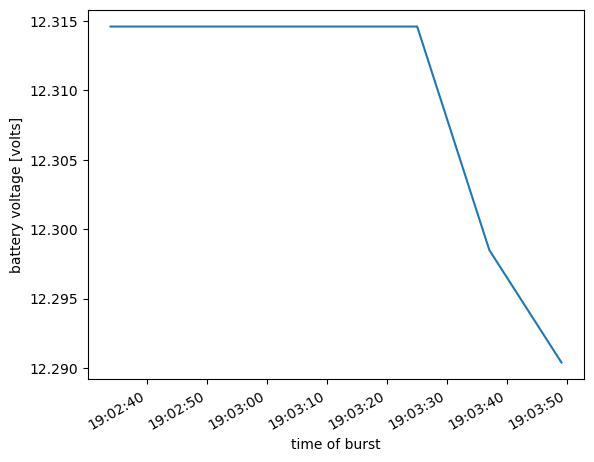

In [20]:
test_207.battery_voltage.plot()

## 207 second test
I did a second test of 107 to double check this timing issue (it was inside without the antennas and gps cables connected). I manually timed the time between the start of bursts (using the stopwatch on my phone and looking at the light on the side which indicates when a burst is happening). I found that the time between bursts was 30 seconds, as expected.

In [21]:
test_207_second = xa.load.generate_xarray(directory=directories['207_secondTest'])
test_207_second

<xarray.Dataset>
Dimensions:          (time: 10, chirp_time: 40001, chirp_num: 2,
                      attenuator_setting_pair: 2, profile_range: 16644)
Coordinates:
  * time             (time) datetime64[ns] 2024-06-03T17:58:37 ... 2024-06-03...
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 3.5e+03 3.5e+03
  * chirp_num        (chirp_num) int64 0 1
    filename         (time) <U47 'data/DIR2024-06-03-1758/DATA2024-06-03-1758...
    burst_number     (time) int64 0 1 2 3 4 5 6 7 8 9
    AFGain           (attenuator_setting_pair) int64 -14 -4
    attenuator       (attenuator_setting_pair) float64 6.0 10.0
    orientation      (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    longitude        (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    battery_voltage  (time) float64 12.38 12.37 12.37 ... 12.35 12.35 12.35
    temperature_1    (time) float64 19.87 22.8 22.8 22.41 ... 27.7 26.33 25.35
    temperature_2    (time) float64 25.76 26.55 27.72 27.91 ... 25.56 28.7 30.66

This second test has a regular interval of 30 seconds between bursts:

In [22]:
(test_207_second.time.values[1:] - test_207_second.time.values[:-1])/1e9 # the /1e9 is because the time is in nanoseconds

array([22, 30, 30, 30, 30, 30, 30, 30, 30], dtype='timedelta64[ns]')

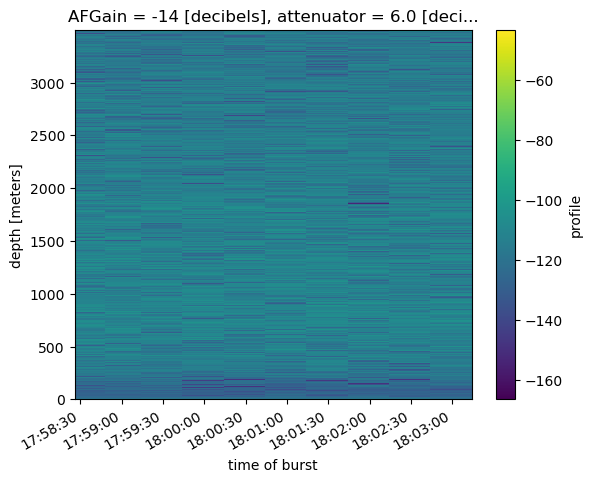

In [23]:
test_207_second.profile.mean(dim='chirp_num').dB().isel(attenuator_setting_pair=0).plot(x='time')

## Proposed procedure for correcting for timing drift
Unit 206 does not appear to connect to the GPS. The purpose of the GPS is to provide accurate timing information. The ApRES unit has an internal clock that is used to time the chirps. The internal clock is not as accurate as the GPS clock, so the ApRES unit uses the GPS clock to correct the internal clock. The internal clock drifts over time. According to Keith Nichols, this drift could be around 20 minutes a year. Keith also said that the drift is linear in time, i.e. the rate at which the internal ApRES clock drifts away from true time is constant. 

Twenty minutes per year is large enough that we would want to correct for it, given that we are going to be making measurements every 30-60 minutes. Given that it is linear the following precedure should work for corrrecting for the drift:
- during installation, manually chnage the time on the ApRES unit to UTC time in the housekeeping screen when in attended mode. This could be done in the morning of the day of installation. It doesnt need to be done at the exact moment of installtion. 
- UTC time can probably be obtained from a hand-held GPS unit
- when the ApRES unit is revisited either at the end of the season, or the following season, the time on the APRES unit should be recorded and sompared to UTC time. The important thing to record wold be the difference in the time displayed on the ApRES housekeeping screen and the handhled GPS, $\delta \tau$.
- If the time between setting the time on the ApRES unit and the time of the revisit if $T$, then the drift rate is $\delta \tau / T$.
- the time of each burst $t$ can be corrected as follows: $t_{\text{corrected}} = t + \delta \tau / T \times t$.  

## Summary
The three ApRES units we are sending south in June 2024 are working. One (206) cannot connect to the GPS, but we have a work around for that. It is possible to complicate the loading of the data by accidently turning off the unit before it is done writing the last burst to disk. This a) isnt a big deal because the one would only lose the last burst, and b) can easily be avoided by checking that the red light on the side of the unit is off and has been for at least ten seconds or so before turning it off. The python package xapres could be a useful way of loading inspecting data in the field. This would involve installing a python environment on the field laptops and making sure everyone knows how to use the package. Maybe matlab is easier, but we can discuss this.  

### note on python environment
If we do want to create a python environment on the field laptops, we could use the following conda command int he terminal to create an environment with the necessary packages:

```
conda create --name envname --file ../../environment.yml
```